# Combine the complete environmental and taxa data sets in October

## Background

The complete raw data sets of environmental and taxa have been provided.
New rows and columns appear in the new sets compared to the sub-sets in summer.

Therefore, we need to combine the two complete raw data sets into one data frame for further analysis.

In [37]:
import pandas as pd

taxa = pd.read_excel("../data/raw/complete_data_sets/taxa_data_set_all_sites.xlsx", sheet_name="all_samples")
environmental = pd.read_excel("../data/raw/complete_data_sets/environmental_data_all_sites.xlsx", sheet_name="all_samples")

# read the resulting cluster labels in 2008
corridor_clusters = pd.read_excel("../data/raw/complete_data_sets/taxa_data_set_all_sites.xlsx",
                                  sheet_name="corridor_clusters")
DR_cluster = pd.read_excel("../data/raw/complete_data_sets/taxa_data_set_all_sites.xlsx",
                                  sheet_name="DR_clusters")
print("The two data sets and the cluster labels have been read successfully.")

The two data sets and the cluster labels have been read successfully.


Check the shapes of the data sets and the cluster labels from 2008 results.

In [38]:
# print the shapes of the data sets and the cluster labels
print("Taxa dataset shape:", taxa.shape)
print("Environmental dataset shape:", environmental.shape)
print("Corridor clusters shape:", corridor_clusters.shape)
print("DR clusters shape:", DR_cluster.shape)
print("\n" + "="*50 + "\n")

print("Taxa dataset - first 5 columns:")
print(taxa.iloc[:3, :5])
print("\n" + "="*50 + "\n")

print("Environmental dataset - first 5 columns:")
print(environmental.iloc[:3, :5])
print("\n" + "="*50 + "\n")

print("Corridor clusters dataset - first 5 columns:")
print(corridor_clusters.iloc[:3, :5])
print("\n" + "="*50 + "\n")

print("DR clusters dataset - first 5 columns:")
print(DR_cluster.iloc[:3, :5])

Taxa dataset shape: (311, 21)
Environmental dataset shape: (323, 13)
Corridor clusters shape: (311, 2)
DR clusters shape: (213, 2)


Taxa dataset - first 5 columns:
  StationID Waterbody   Latitude  Longitude  Year
0    003ABC        DR  42.353685 -82.944344  1999
1    004ABC        DR  42.350308 -82.934247  1999
2    005ABC        DR  42.342434 -82.945587  1999


Environmental dataset - first 5 columns:
  StationID    Year Waterbody   Latitude  Longitude
0      001A     NaN        DR  42.346447 -82.918068
1    003ABC  1999.0        DR  42.353685 -82.944344
2    004ABC  1999.0        DR  42.350308 -82.934247


Corridor clusters dataset - first 5 columns:
  StationID  corridor_cluster
0    003ABC                 1
1    004ABC                 1
2    005ABC                 1


DR clusters dataset - first 5 columns:
  StationID  DR_cluster
0    005ABC           1
1    007ABC           1
2      008A           1


## Set the unique identifier and sort by the identifier

The stationID(processed by the author) is the unique identifier for all three data sets. 
It is used to filter intersection and sort the rows in the same order for all three data sets.

In [39]:
%load_ext autoreload
%autoreload 2

from zci.data_process.dataframe_ops import wrap_columns, add_site_block, concat_blocks, flatten_columns, get_block, align_blocks_by_index
from zci.data_process.transform import hellinger_transform, log1p_standardize

# set the index to "StationID" and sort the index for both dataframes
taxa = taxa.set_index("StationID").sort_index()
environmental = environmental.set_index("StationID").sort_index()

# strict intersection and update the tables (keep the rows(identifiers) only if they are present in both dataframes)
taxa, environmental = align_blocks_by_index([taxa, environmental], how ='inner')

# check the updated shapes of the data sets
print("Intersected Taxa dataset shape:", taxa.shape)
print("Intersected Environmental dataset shape:", environmental.shape)
print("\n" + "="*50 + "\n")

print("Intersected Taxa dataset - first 5 columns:")
print(taxa.iloc[:3, :5])
print("\n" + "="*50 + "\n")

print("Intersected Environmental dataset - first 5 columns:")
print(environmental.iloc[:3, :5])
print("\n" + "="*50 + "\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Intersected Taxa dataset shape: (311, 20)
Intersected Environmental dataset shape: (311, 12)


Intersected Taxa dataset - first 5 columns:
          Waterbody   Latitude  Longitude  Year  Oligochaeta
StationID                                                   
003ABC           DR  42.353685 -82.944344  1999     2.269984
004ABC           DR  42.350308 -82.934247  1999     3.808504
005ABC           DR  42.342434 -82.945587  1999     4.820163


Intersected Environmental dataset - first 5 columns:
             Year Waterbody   Latitude  Longitude  LOI (%)
StationID                                                 
003ABC     1999.0        DR  42.353685 -82.944344     1.14
004ABC     1999.0        DR  42.350308 -82.934247     0.78
005ABC     1999.0        DR  42.342434 -82.945587     0.53




## Extract the general sampling information: year, location

There are some general sampling information columns in all three data sets: year, location (stationID, latitude, longitude), waterbody. They are repeated and only need to be kept once after merging the three. 

These columns are extracted here from one data set (taxa data set) and dropped from the other two data sets (environmental and stressor data sets).

In [40]:
# take out the general sampling information: year, location (stationID, latitude, longitude), waterbody
sample_info = taxa[["Year", "Latitude", "Longitude", "Waterbody"]]

# drop the same columns from the two sets
taxa = taxa.drop(columns=["Year", "Latitude", "Longitude", "Waterbody"])
environmental = environmental.drop(columns=["Year", "Latitude", "Longitude", "Waterbody"])

# check the sample_info and the updated shapes of the data sets
print("Sample info shape:", sample_info.shape)
print("Sample info - first 5 columns:")
print(sample_info.iloc[:3, :5])
print("\n" + "="*50 + "\n")

Sample info shape: (311, 4)
Sample info - first 5 columns:
           Year   Latitude  Longitude Waterbody
StationID                                      
003ABC     1999  42.353685 -82.944344        DR
004ABC     1999  42.350308 -82.934247        DR
005ABC     1999  42.342434 -82.945587        DR




## Two types of Cluster Labels from 2008 results

With the complete data sets, there are two types of cluster labels from the 2008 results:
1. Cluster labels across corridors: 
   - All the 311 sites are clustered into 2 clusters, no indicator showing reference sites.
2. Cluster labels within Detroit River:
   - The 213 sites are clustered into 3 clusters, an extra indicator showing reference sites in each cluster.

### Align the Detroit River cluster labels with the complete data sets
Map the shape (213, 3) to (311, 3) by filling NaN with 0 for the non-Detroit River sites, so that the two types of cluster labels can be compared directly and are aligned for merging with the complete data sets.

In [41]:
# set and sort the index for the cluster labels dataframes
corridor_clusters = corridor_clusters.set_index("StationID").sort_index()
DR_cluster = DR_cluster.set_index("StationID").sort_index()

# insert the DR cluster labels as a subset into the corridor cluster by filling NaN with 0
corridor_clusters["DR_cluster"] = corridor_clusters.index  # add a column for DR cluster with all 0s
corridor_clusters["DR_cluster"] = corridor_clusters["DR_cluster"].apply(
    lambda x: DR_cluster.loc[x, "DR_cluster"] if x in DR_cluster.index else 0)

corridor_clusters

,corridor_cluster,DR_cluster
StationID,,
003ABC,1,3
004ABC,1,3
005ABC,1,1
007ABC,1,1
008A,1,1
...,...,...
S99,1,2
UBC1,1,0
UCC1,1,0


### Extract the reference indicator from the environmental data set

These reference indicator columns are not environmental variables, they are cluster labels and can be dropped off safely from environmental type.

Here I put these reference indicator columns into the cluster labels data frame for better organization.
The NaN values are filled with 0 for the non-Detroit River sites.

In [42]:
# take out the reference indicator columns from the environmental data set
DR_ref_indicator = environmental["RelMax RefSite"].fillna(0).astype(int)
# map the reference indicator to the cluster labels data frame
corridor_clusters["if_RF"] = DR_ref_indicator # they are sorted and aligned by index already

# drop these cluster labels and reference indicator columns from the environmental data set
environmental = environmental.drop(columns=["clusters", "RelMax RefSite"])
# check the updated shapes of the data sets and the cluster labels
print("Updated Environmental dataset shape:", environmental.shape)
print("Cluster labels shape:", corridor_clusters.shape)
print("\n" + "="*50 + "\n")

print("Updated Environmental dataset - first 5 columns:")
print(environmental.iloc[:3, :7])
print("\n" + "="*50 + "\n")

Updated Environmental dataset shape: (311, 6)
Cluster labels shape: (311, 3)


Updated Environmental dataset - first 5 columns:
           LOI (%)  Measured Depth (m)  Temperature (oC)  \
StationID                                                  
003ABC        1.14              5.9436              15.0   
004ABC        0.78              3.2004              15.5   
005ABC        0.53              1.2192              17.0   

           Water DO Bottom (mg/L)  MPS (Phi)  Velocity  at bottom (m/sec)  
StationID                                                                  
003ABC                        9.8   0.555556                      0.37186  
004ABC                       10.6   0.566667                      0.44179  
005ABC                        9.0   0.642857                      0.08216  




In [43]:
# seperate the DR cluster labels and reference indicator columns from the corridor cluster labels dataframe
DR_cluster = corridor_clusters[["DR_cluster", "if_RF"]]
corridor_clusters = corridor_clusters.drop(columns=["DR_cluster", "if_RF"])

# Wrap these dataframes with multi-column index and merge them into a single dataframe

## 5 seperate dataframes to be wrapped and merged

1. **sample_info**: include the year, location, waterbody information
2. **corridor_clusters**: the cluster results from 2008 across corridors
3. **DR_cluster**: the cluster results from 2008 within Detroit River
4. **environmental**: the pure environmental variables
5. **taxa**: the pure taxa variables

All these dataframe have the intersection identifiers (StationID) and have been sorted by the 
identifier(faster access).

In [44]:
# wrap theese dataframes with multi-column index
sample_info = wrap_columns(sample_info, "sample_info", "raw")
corridor_clusters = wrap_columns(corridor_clusters, "2008_results", "corridor_clusters")
DR_cluster = wrap_columns(DR_cluster, "2008_results", "DR_clusters")
taxa = wrap_columns(taxa, "taxa", "raw")
environmental = wrap_columns(environmental, "environmental", "raw")

# merge all the dataframes into a single dataframe
master = concat_blocks([sample_info, corridor_clusters, DR_cluster, environmental, taxa])
# reorder the top level columns
master = master.reindex(columns=["sample_info", "environmental", "taxa", "2008_results"], level=0)
master.head()

block     sample_info                            environmental            \
subblock          raw                                      raw             
var          Latitude  Longitude Waterbody  Year       LOI (%) MPS (Phi)   
StationID                                                                  
003ABC      42.353685 -82.944344        DR  1999      1.140000  0.555556   
004ABC      42.350308 -82.934247        DR  1999      0.780000  0.566667   
005ABC      42.342434 -82.945587        DR  1999      0.530000  0.642857   
007ABC      42.344791 -82.936142        DR  1999      4.173333  2.238095   
008A        42.350944 -82.922672        DR  1999      0.820000  0.647059   

block                                                                      \
subblock                                                                    
var       Measured Depth (m) Temperature (oC) Velocity  at bottom (m/sec)   
StationID                                                                   
003ABC                5.9436             15.0                     0.37186   
004ABC                3.2004             15.5                     0.44179   
005ABC                1.2192             17.0                     0.08216   
007ABC                8.0772             16.0                     0.14675   
008A                  2.1336             16.0                     0.18312   

block                             ...           taxa                          \
subblock                          ...            raw                           
var       Water DO Bottom (mg/L)  ... Hydropsychidae      Hydrozoa  Nematoda   
StationID                         ...                                          
003ABC                       9.8  ...   2.438439e+00  3.203427e-16  0.563546   
004ABC                      10.6  ...   3.203427e-16  3.203427e-16  3.512091   
005ABC                       9.0  ...   3.203427e-16  3.203427e-16  5.519382   
007ABC                       9.3  ...   3.203427e-16  1.820930e+00  0.181596   
008A                        12.5  ...   1.284384e-01  3.203427e-16  0.246371   

block                                                                \
subblock                                                              
var       Oligochaeta Other Trichoptera   Sphaeriidae   Turbellaria   
StationID                                                             
003ABC       2.269984      3.203427e-16  3.203427e-16  3.203427e-16   
004ABC       3.808504      3.203427e-16  3.203427e-16  3.203427e-16   
005ABC       4.820163      3.203427e-16  3.203427e-16  3.203427e-16   
007ABC       1.449187      3.203427e-16  3.203427e-16  3.203427e-16   
008A         1.082238      3.203427e-16  3.203427e-16  3.203427e-16   

block     2008_results                          
subblock   DR_clusters       corridor_clusters  
var         DR_cluster if_RF  corridor_cluster  
StationID                                       
003ABC               3     0                 1  
004ABC               3     0                 1  
005ABC               1     0                 1  
007ABC               1     0                 1  
008A                 1     0                 1  

[5 rows x 29 columns]

In [45]:
# check the information in the merged dataframe
master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311 entries, 003ABC to UJC1
Data columns (total 29 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   (sample_info, raw, Latitude)                         311 non-null    float64
 1   (sample_info, raw, Longitude)                        311 non-null    float64
 2   (sample_info, raw, Waterbody)                        311 non-null    object 
 3   (sample_info, raw, Year)                             311 non-null    int64  
 4   (environmental, raw, LOI (%))                        311 non-null    float64
 5   (environmental, raw, MPS (Phi))                      311 non-null    float64
 6   (environmental, raw, Measured Depth (m))             311 non-null    float64
 7   (environmental, raw, Temperature (oC))               311 non-null    float64
 8   (environmental, raw, Velocity  at bottom (m/sec))    213 non-null    

In [46]:
# master.to_excel("../data/processed/complete_env_taxa.xlsx", sheet_name="all_data_merged")

## Pre-merging operation: stressor data sets

The complete stressor data set is not available yet, but there are a subset of around 104 sites available.

I will do the pre-merging operation here with the subset stressor data set, and update the merging operation when the complete stressor data set is available.

This stressor subset will be wrapped and merged in the same way the the other 5 dataframes. Adding it to the merged dataframe
will narrarrow down the rows to its intersection with the other 5 dataframes.

In [47]:
# read the stressor subset
chemical = pd.read_excel("../data/raw/from_proposal/chemical_data.xlsx")
# set the StatinID as index and sort by 
chemical = chemical.set_index("StationID").sort_index()
chemical.head()

,Al,As,Bi,Ca,Cd,Co,Cr,Cu,Fe,Hg,...,1245-TCB,1234-TCB,QCB,HCB,OCS,"p,p'-DDE","p,p'-DDD",mirex,Heptachlor Epoxide,total PCB
StationID,,,,,,,,,,,,,,,,,,,,,
A10,3041,1.939,18.45000,28170,0.2950,2.723,8.766,17.64,7462,0.03831,...,0.775732,0.835583,0.125824,0.626257,0.283217,0.239245,0.523188,0.000000,0.0,2.493820
A23,4483,2.512,17.03000,42110,0.3986,4.009,10.850,17.28,8600,0.36430,...,0.697265,0.639983,0.927448,6.168432,0.000000,0.452774,0.781357,0.193857,0.0,6.775272
A27,13620,2.759,0.05370,41610,0.2180,6.273,21.080,25.00,16940,0.10360,...,0.815149,0.451838,0.114867,0.273647,0.454157,0.458433,1.825673,0.514213,0.0,7.429817
A28,12750,2.609,0.06617,33280,0.1197,5.824,18.700,24.07,16270,0.15680,...,0.483363,0.224379,0.224762,0.937388,0.144927,0.586789,1.867356,0.000000,0.0,2.122595
A29,23740,3.735,0.15290,40450,0.1536,9.618,44.370,44.72,27500,0.37430,...,0.695356,0.299715,0.373344,1.294264,0.831924,0.497881,0.374731,0.986737,0.0,5.937485


In [48]:
from zci.data_process.dataframe_ops import concat_blocks
# filter the master dataframe to keep only the rows with the StiationID existing in the chemical
master = master.loc[chemical.index]

# wrap the chemical dataframe and merge it to the same-length master dataframe
chemical = wrap_columns(chemical, "chemical", "raw")
master = concat_blocks([master, chemical])

# reorder the top level columns again to put the chemical block before the taxa block
master = master.reindex(columns=["sample_info", "environmental", "chemical", "taxa", "2008_results"], level=0)
master.head()

block     sample_info                           environmental            \
subblock          raw                                     raw             
var          Latitude Longitude Waterbody  Year       LOI (%) MPS (Phi)   
StationID                                                                 
A10          42.90455 -82.46760       SCR  2004      3.436193  1.734259   
A23          42.56658 -82.57595       LSC  2004      3.226637  1.969984   
A27          42.56007 -82.42132       LSC  2004      2.802642  1.319519   
A28          42.54577 -82.42073       LSC  2004      3.201399  1.398687   
A29          42.51440 -82.43462       LSC  2004      6.180718  1.065748   

block                                                                      \
subblock                                                                    
var       Measured Depth (m) Temperature (oC) Velocity  at bottom (m/sec)   
StationID                                                                   
A10                      1.8            19.17                         NaN   
A23                      3.0            19.10                         NaN   
A27                      1.0            18.40                         NaN   
A28                      0.5            18.90                         NaN   
A29                      0.5            19.30                         NaN   

block                             ...           taxa                          \
subblock                          ...            raw                           
var       Water DO Bottom (mg/L)  ... Hydropsychidae      Hydrozoa  Nematoda   
StationID                         ...                                          
A10                        10.21  ...   3.203427e-16  3.203427e-16  1.727234   
A23                        10.09  ...   3.203427e-16  3.203427e-16  2.427993   
A27                        10.30  ...   3.203427e-16  3.203427e-16  1.802219   
A28                        12.80  ...   3.203427e-16  3.203427e-16  2.771800   
A29                         9.70  ...   3.203427e-16  3.203427e-16  4.616441   

block                                                                \
subblock                                                              
var       Oligochaeta Other Trichoptera   Sphaeriidae   Turbellaria   
StationID                                                             
A10          6.576942      3.203427e-16  3.203427e-16  3.203427e-16   
A23          5.872905      3.203427e-16  1.022139e+00  5.997595e-01   
A27          6.402280      1.580169e+00  1.317615e+00  9.964067e-01   
A28          5.867874      2.049287e+00  2.863547e+00  3.203427e-16   
A29          5.181664      3.203427e-16  3.203427e-16  3.203427e-16   

block     2008_results                          
subblock   DR_clusters       corridor_clusters  
var         DR_cluster if_RF  corridor_cluster  
StationID                                       
A10                  0     0                 1  
A23                  0     0                 1  
A27                  0     0                 1  
A28                  0     0                 1  
A29                  0     0                 1  

[5 rows x 59 columns]

## Save the merged dataframe for the use in the next steps

In [49]:
master.to_excel("../data/processed/complete_env_taxa_chemical.xlsx", sheet_name="all_data_merged")

# Make a data transformation on the wrapped dataframe

Given we have a transformation function called hellinger_transform imported from other modules, we can apply this function to the wrapped dataframe to make the data transformation on the taxa variables.

In [50]:
from zci.data_process.transform import hellinger_transform
from zci.data_process.dataframe_ops import get_block # function to fetch the wanted block from the wrapped dataframe


# Apply hellinger transformation on the raw taxa data
taxa_hell = hellinger_transform(get_block(master, "taxa", "raw"))
taxa_hell.head()

var,Acari,Amphipoda,Caenis,Ceratopogonidae,Chironomidae,Dreissena,Gastropoda,Hexagenia,Hirudinea,Hydropsychidae,Hydrozoa,Nematoda,Oligochaeta,Other Trichoptera,Sphaeriidae,Turbellaria
StationID,,,,,,,,,,,,,,,,
A10,5.554818e-09,5.554818e-09,5.554818e-09,5.554818e-09,0.447355,5.554818e-09,5.554818e-09,5.554818e-09,5.554818e-09,5.554818e-09,5.554818e-09,0.407885,0.795929,5.554818e-09,5.554818e-09,5.554818e-09
A23,4.069392e-09,4.069392e-09,1.760803e-01,9.507910e-02,0.503314,4.069392e-09,2.189748e-01,3.817414e-01,4.069392e-09,4.069392e-09,4.069392e-09,0.354279,0.550996,4.069392e-09,2.298673e-01,1.760803e-01
A27,4.395591e-09,4.395591e-09,4.395591e-09,4.395591e-09,0.436813,4.395591e-09,4.395591e-09,2.819059e-01,4.395591e-09,4.395591e-09,4.395591e-09,0.329696,0.621409,3.087178e-01,2.819059e-01,2.451479e-01
A28,3.755893e-09,3.755893e-09,3.755893e-09,3.755893e-09,0.432265,3.755893e-09,3.755893e-09,3.004050e-01,3.551060e-01,3.755893e-09,3.755893e-09,0.349371,0.508331,3.004050e-01,3.551060e-01,3.755893e-09
A29,4.246716e-09,4.246716e-09,4.246716e-09,4.246716e-09,0.540108,4.246716e-09,4.246716e-09,3.958173e-01,4.246716e-09,4.246716e-09,4.246716e-09,0.509800,0.540108,4.246716e-09,4.246716e-09,4.246716e-09


A straightforward visualization to show the transformation did make changes to the data.

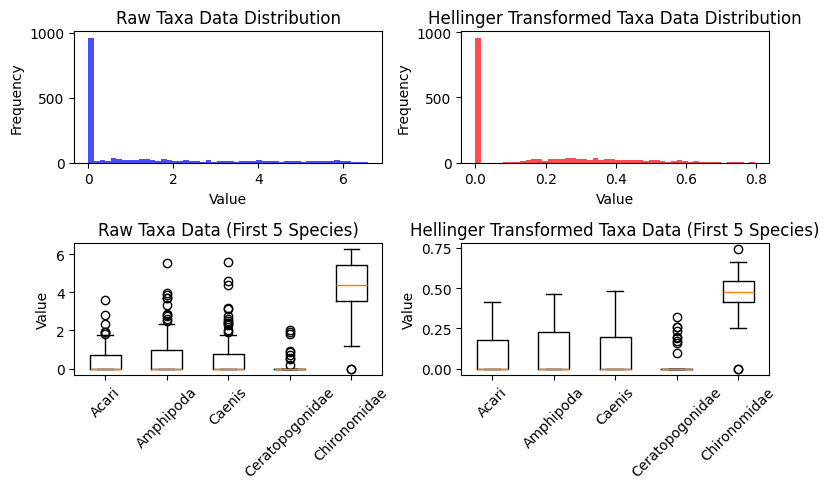

In [51]:
import matplotlib.pyplot as plt

# Get the raw taxa data for comparison
taxa_raw = get_block(master, "taxa", "raw")

# Create subplots for before and after comparison
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# Plot raw taxa data distribution
axes[0, 0].hist(taxa_raw.values.flatten(), bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Raw Taxa Data Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

# Plot hellinger transformed taxa data distribution
axes[0, 1].hist(taxa_hell.values.flatten(), bins=50, alpha=0.7, color='red')
axes[0, 1].set_title('Hellinger Transformed Taxa Data Distribution')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

# Plot boxplot for raw data
axes[1, 0].boxplot([taxa_raw[col] for col in taxa_raw.columns[:5]], 
                   tick_labels=taxa_raw.columns[:5])
axes[1, 0].set_title('Raw Taxa Data (First 5 Species)')
axes[1, 0].set_ylabel('Value')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot boxplot for transformed data
axes[1, 1].boxplot([taxa_hell[col] for col in taxa_hell.columns[:5]], 
                   tick_labels=taxa_hell.columns[:5])
axes[1, 1].set_title('Hellinger Transformed Taxa Data (First 5 Species)')
axes[1, 1].set_ylabel('Value')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()